###1) Target:

We want increase the training and test performance. To accomplish this goal, we introduce random rotation.

###2) Results:
Number of Parameters: 5,688 (previous 5,544)

Best Train Accuracy: 98.71 (was 98.99) (was 98.36) (was 99.22) (previous 98.34) (previous 98.59)

Best Test Accuracy: 99.17 (was 99.2) (was 99.12) (was 99.13) (previous98.46) (previous 98.56)

###3) Analysis:
Number of parameters remain same. 

We introduced random rotation.

There is a slight decrease in training accuracy. 

There is very minimal drop in test accuracy.

Image augmentation has not helped here.

We are still below our target accuracy of 99.4 in 15 epochs. We will try to play around with learning rates and see if it helps in increasing the performance.


# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):

      super().__init__()
      
      self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, bias=False),
                                 nn.BatchNorm2d(8),
                                 nn.ReLU(inplace=True), #8*26*26
                                 nn.Dropout(0.02),
                                 nn.Conv2d(8, 16, 3, bias=False),
                                 nn.BatchNorm2d(16),
                                 nn.ReLU(inplace=True), #16*24*24
                                 nn.Dropout(0.02)
      )

      self.trans = nn.Sequential(nn.MaxPool2d(2,2), #16*12*12
                                 nn.Conv2d(16,8,1, bias=False),
                                 nn.BatchNorm2d(8),
                                 nn.ReLU(inplace=True), #8*12*12
                                 nn.Dropout(0.02)
                                 )

      self.conv2 = nn.Sequential(nn.Conv2d(8, 8, 3, bias=False),
                                 nn.BatchNorm2d(8),
                                 nn.ReLU(inplace=True), #8*10*10
                                 nn.Dropout(0.02),
                                 nn.Conv2d(8, 16, 3, bias=False),
                                 nn.BatchNorm2d(16),
                                 nn.ReLU(inplace=True), #16*8*8
                                 nn.Dropout(0.02),
                                 nn.Conv2d(16, 16, 3, bias=False),#16*6*6
                                 nn.BatchNorm2d(16),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(0.02)
                                 )

      self.output = nn.Sequential(nn.Conv2d(16, 10, 1, bias=False)) #10*6*6
      self.avgpool2d = nn.AvgPool2d(kernel_size=6) #10*1*1


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans(x)
        x = self.conv2(x)
        x = self.output(x)
        x = self.avgpool2d(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14            [-

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing
 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.23937825858592987 Batch_id=468 Accuracy=80.79: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]



Test set: Average loss: 0.1535, Accuracy: 9638/10000 (96.38%)

EPOCH: 1


Loss=0.12774395942687988 Batch_id=468 Accuracy=96.72: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s]



Test set: Average loss: 0.0740, Accuracy: 9806/10000 (98.06%)

EPOCH: 2


Loss=0.055089935660362244 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]



Test set: Average loss: 0.0769, Accuracy: 9786/10000 (97.86%)

EPOCH: 3


Loss=0.07901667803525925 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]



Test set: Average loss: 0.0487, Accuracy: 9864/10000 (98.64%)

EPOCH: 4


Loss=0.08404915779829025 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]



Test set: Average loss: 0.0399, Accuracy: 9881/10000 (98.81%)

EPOCH: 5


Loss=0.02369115687906742 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]



Test set: Average loss: 0.0422, Accuracy: 9872/10000 (98.72%)

EPOCH: 6


Loss=0.019352559000253677 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]



Test set: Average loss: 0.0429, Accuracy: 9870/10000 (98.70%)

EPOCH: 7


Loss=0.03577152267098427 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]



Test set: Average loss: 0.0340, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Loss=0.19838078320026398 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]



Test set: Average loss: 0.0402, Accuracy: 9878/10000 (98.78%)

EPOCH: 9


Loss=0.029452435672283173 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]



Test set: Average loss: 0.0289, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.014338717795908451 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 32.24it/s]



Test set: Average loss: 0.0299, Accuracy: 9908/10000 (99.08%)

EPOCH: 11


Loss=0.052766505628824234 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]



Test set: Average loss: 0.0285, Accuracy: 9908/10000 (99.08%)

EPOCH: 12


Loss=0.044901203364133835 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]



Test set: Average loss: 0.0289, Accuracy: 9910/10000 (99.10%)

EPOCH: 13


Loss=0.05075652897357941 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]



Test set: Average loss: 0.0350, Accuracy: 9891/10000 (98.91%)

EPOCH: 14


Loss=0.1192876324057579 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 33.10it/s]



Test set: Average loss: 0.0266, Accuracy: 9917/10000 (99.17%)



Text(0.5, 1.0, 'Test Accuracy')

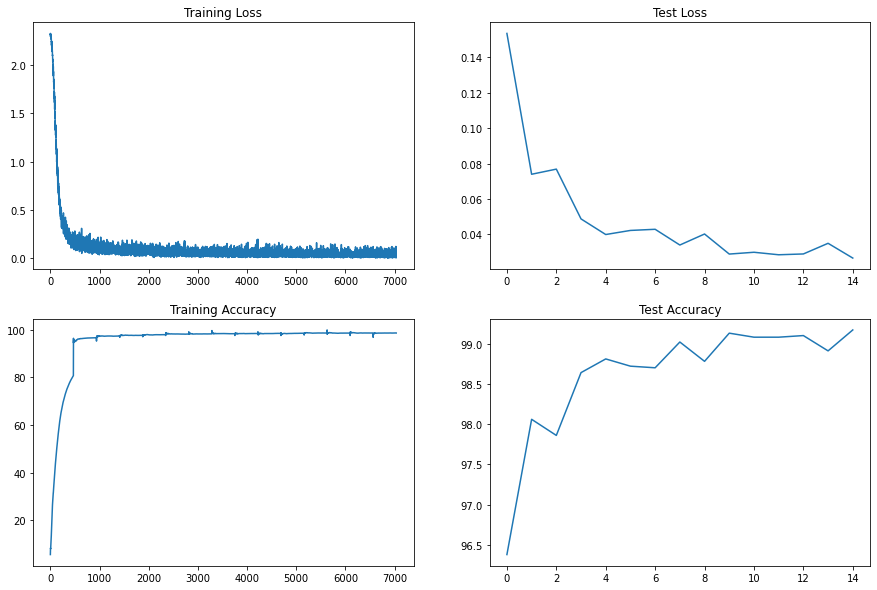

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")